In [64]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [65]:
def apply_transformation(image) :
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    _, otsu_thresholded = cv2.threshold(blurred_image, 165, 255, cv2.THRESH_BINARY)
    edges_image = cv2.Canny(otsu_thresholded, threshold1=50, threshold2=150)
    dilation_kernel = np.ones((3, 3), np.uint8)
    dilated_image = cv2.dilate(edges_image, dilation_kernel, iterations=1)
    lines = cv2.HoughLinesP(dilated_image, 1, np.pi/180, threshold=200, minLineLength=100, maxLineGap=25)
    hough_image = dilated_image
    if lines is not None:
        for i, line in enumerate(lines):
            x1, y1, x2, y2 = line[0]
            cv2.line(hough_image, (x1, y1), (x2, y2), (255,255,255), 3)

    erosion_kernel = np.ones((3, 3), np.uint8)
    erosed_image = cv2.erode(hough_image, erosion_kernel, iterations=1)
    return erosed_image

In [66]:
def get_red_line(image) :
    lines = cv2.HoughLines(image, rho=1, theta=np.pi/180, threshold=250)
    output_lines = []
    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            output_lines.append([x1,y1,x2,y2])
    return output_lines

In [67]:
def put_red_lines(image, lines) :
    if lines is not None:
        for line in lines:
            x1,y1,x2,y2 = line
            cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
    return image

In [68]:
def get_raw_oriented_line(image) : 
    lines = cv2.HoughLines(image, rho=1, theta=np.pi/180, threshold=250)
    horizontal_lines = []
    vertical_lines = []
    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            if np.pi / 2 - 0.1 <= theta <= np.pi / 2 + 0.1:
                horizontal_lines.append((rho, theta))
            elif theta <= 0.1 or theta >= np.pi - 0.1:
                vertical_lines.append((rho, theta))
    return (horizontal_lines, vertical_lines)

In [69]:
def get_oriented_line(image) :
    horizontal_lines, vertical_lines = get_raw_oriented_line(image)
    output_horizontal_lines = []
    output_vertical_ilnes = []
    # Draw horizontal lines
    for rho, theta in horizontal_lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        output_horizontal_lines.append([x1,y1,x2,y2])
    # Draw vertical lines
    for rho, theta in vertical_lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        output_vertical_ilnes.append([x1,y1,x2,y2])
    return output_horizontal_lines, output_vertical_ilnes


In [70]:
def put_oriented_line(image, horizontal_lines, vertical_lines) :
    for h_line in horizontal_lines:
        x1, y1, x2, y2 = h_line
        cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2)
    for v_line in vertical_lines:
        x1, y1, x2, y2 = v_line
        cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    return image


In [71]:
def get_intersection_point(image) : 
    horizontal_lines, vertical_lines = get_raw_oriented_line(image)
    intersection_points = []

    for rho_h, theta_h in horizontal_lines:
        for rho_v, theta_v in vertical_lines:
            a_h = np.cos(theta_h)
            b_h = np.sin(theta_h)
            a_v = np.cos(theta_v)
            b_v = np.sin(theta_v)
            determinant = a_h * b_v - b_h * a_v
            if abs(determinant) > 1e-10: 
                x = (b_v * rho_h - b_h * rho_v) / determinant
                y = (a_h * rho_v - a_v * rho_h) / determinant
                intersection_points.append((int(x), int(y)))
    return intersection_points

In [72]:
def put_intersection_point(image,intersection_points) :
    for x, y in intersection_points:
        cv2.circle(image, (x, y), 1, (0, 0, 255), -1)
    return image

In [97]:
def get_corner(image, intersection_points) :
    red_regions = cv2.cvtColor(put_intersection_point(image * 0, intersection_points), cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(red_regions, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
    threshold = 0.01 * dst.max()
    corners = np.argwhere(dst > threshold)
    height, width = gray.shape
    image_corners = [
        (0, 0),               # Top-left
        (0, height - 1),       # Top-right 0, width - 1
        (width - 1, 0),      # Bottom-left height - 1, 0
        (height - 1, width - 1)  # Bottom-right
    ]
    refined_corners = []
    for corner in image_corners:
        distances = np.linalg.norm(corners - np.array(corner), axis=1)
        closest_idx = np.argmin(distances)
        refined_corners.append([corners[closest_idx][1],corners[closest_idx][0]])
    
    return refined_corners


In [101]:
def apply_crop_image(image, corners) :
    corners = np.float32(corners)
    src_points = corners
    dst_points = np.float32([
        [0, 0],
        [500, 0],
        [0, 500],
        [500, 500]
    ])
    matrix = cv2.getPerspectiveTransform(src_points, dst_points)
    output_size = (500, 500) 
    warped_image = cv2.warpPerspective(image, matrix, output_size)
    
    return warped_image

In [103]:
def apply_sol2(image) :
    transformed_image = apply_transformation(image)
    red_lines = get_red_line(transformed_image)
    horizontal_lines, vertical_lines = get_oriented_line(transformed_image)
    intersection_points = get_intersection_point(transformed_image)
    corners = get_corner(image,intersection_points)
    croped_image = apply_crop_image(image,corners)
    plt.imshow(croped_image)


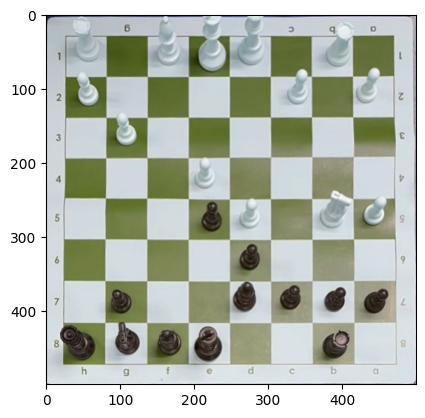

In [105]:
image_path = 'image.jpg'
image = cv2.imread(image_path)
apply_sol2(image)